In [76]:
from matplotlib import pyplot as plt
from PIL import Image
import face_recognition

# Load the jpg file into a numpy array
image = face_recognition.load_image_file(r"D:\trydata\bb.jpg")

# Find all the faces in the image using the default HOG-based model.
# This method is fairly accurate, but not as accurate as the CNN model and not GPU accelerated.
# See also: find_faces_in_picture_cnn.py
face_locations = face_recognition.face_locations(image)

print("I found {} face(s) in this photograph.".format(len(face_locations)))

for face_location in face_locations:

    # Print the location of each face in this image
    top, right, bottom, left = face_location
    print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))

    # You can access the actual face itself like this:
    face_image = image[top:bottom, left:right]
    pil_image = Image.fromarray(face_image)
    pil_image.show()

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\trydata\\bb.jpg'

In [77]:
import face_recognition

picture_of_me = face_recognition.load_image_file(r"D:\trydata\face\j.jpg")
my_face_encoding = face_recognition.face_encodings(picture_of_me)[0]

# my_face_encoding now contains a universal 'encoding' of my facial features that can be compared to any other picture of a face!

unknown_picture = face_recognition.load_image_file(r"D:\trydata\face\b.jpg")
unknown_face_encoding = face_recognition.face_encodings(unknown_picture)[0]

# Now we can see the two face encodings are of the same person with `compare_faces`!

results = face_recognition.compare_faces([my_face_encoding], unknown_face_encoding)

if results[0] == True:
    print("It's a picture of me!")
else:
    print("It's not a picture of me!")

It's not a picture of me!


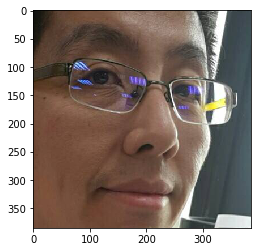

In [10]:
import face_recognition
#有我的臉的圖
picture_of_me = face_recognition.load_image_file(r"D:\trydata\face\jj.jpg")
#我的臉在該圖的位置
my_face_locations = face_recognition.face_locations(picture_of_me)
top, right, bottom, left = my_face_locations[0]
#將我的臉截出來做成特徵
my_face_image = picture_of_me[top:bottom, left:right]
plt.imshow(my_face_image)
plt.show()
my_face_encoding = face_recognition.face_encodings(picture_of_me,my_face_locations)[0]



In [6]:
unknown_picture = face_recognition.load_image_file(r"D:\trydata\face\DSC_3425.jpg")
unknow_face_encoding = face_recognition.face_encodings(unknown_picture)


#尚不知為何、不是第一個要list就是第二個要list  list-array跟array比
face_recognition.compare_faces(my_face_encoding, unknow_face_encoding)



[True, False, True, True, False, True, False, False, False, False, False]

In [9]:
import matplotlib.pyplot as plt

#新的照片
unknown_picture = face_recognition.load_image_file(r"D:\trydata\face\DSC_3425.jpg")

#找到新圖片的臉的位置(可能有很多 所以回傳list)
unknown_face_locations=face_recognition.face_locations(unknown_picture)

NameError: name 'face_recognition' is not defined

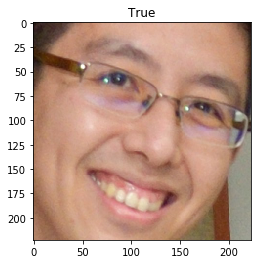

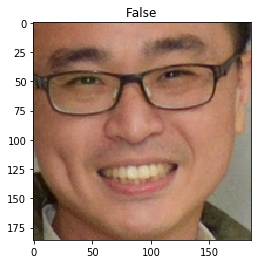

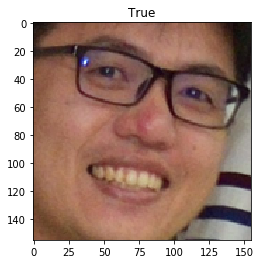

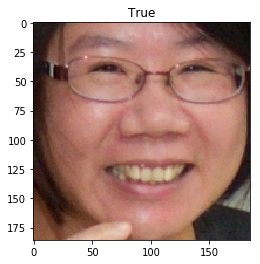

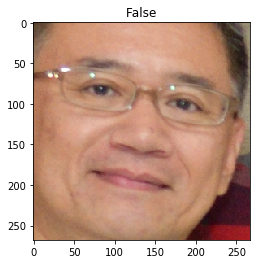

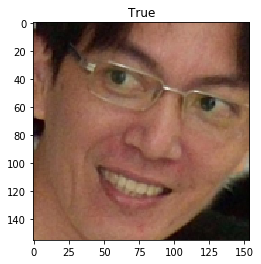

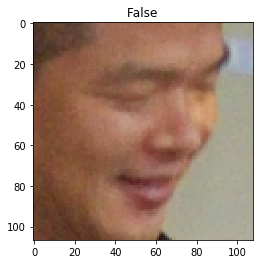

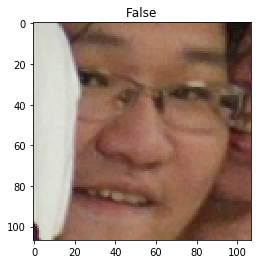

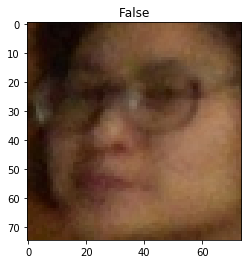

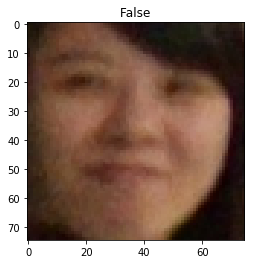

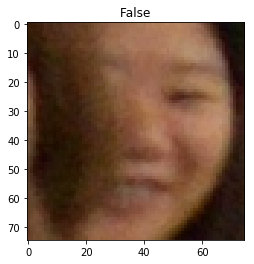

In [8]:
#將每張臉截圖，找到特徵後比對我的臉
for location in unknown_face_locations:
    top, right, bottom, left = location
    unknow_face_image = unknown_picture[top:bottom, left:right]
    unknow_face_encoding = face_recognition.face_encodings(unknown_picture,[location])[0]
    #比對
    results = face_recognition.compare_faces([my_face_encoding], unknow_face_encoding)
    plt.imshow(unknow_face_image)
    plt.title(results[0])
    plt.show()

In [2]:
"""
This is an example of using the k-nearest-neighbors(knn) algorithm for face recognition.

When should I use this example?
This example is useful when you wish to recognize a large set of known people,
and make a prediction for an unkown person in a feasible computation time.

Algorithm Description:
The knn classifier is first trained on a set of labeled(known) faces, and can then predict the person
in an unkown image by finding the k most similar faces(images with closet face-features under eucledian distance) in its training set,
and performing a majority vote(possibly weighted) on their label.
For example, if k=3, and the three closest face images to the given image in the training set are one image of Biden and two images of Obama, 
The result would be 'Obama'.
*This implemententation uses a weighted vote, such that the votes of closer-neighbors are weighted more heavily.

Usage:
-First, prepare a set of images of the known people you want to recognize.
 Organize the images in a single directory with a sub-directory for each known person.
-Then, call the 'train' function with the appropriate parameters.
 make sure to pass in the 'model_save_path' if you want to re-use the model without having to re-train it. 
-After training the model, you can call 'predict' to recognize the person in an unknown image.

NOTE: This example requires scikit-learn to be installed! You can install it with pip:
$ pip3 install scikit-learn
"""
import matplotlib.pyplot as plt
from math import sqrt
from sklearn import neighbors
from os import listdir
from os.path import isdir, join, isfile, splitext
import pickle
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import face_recognition
from face_recognition import face_locations
# from face_recognition.cli import image_files_in_folder




ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}

def train(train_dir, model_save_path = "", n_neighbors = None, knn_algo = 'ball_tree', verbose=False):
    """
    Trains a k-nearest neighbors classifier for face recognition.

    :param train_dir: directory that contains a sub-directory for each known person, with its name.

     (View in source code to see train_dir example tree structure)

     Structure:
        <train_dir>/
        ├── <person1>/
        │   ├── <somename1>.jpeg
        │   ├── <somename2>.jpeg
        │   ├── ...
        ├── <person2>/
        │   ├── <somename1>.jpeg
        │   └── <somename2>.jpeg
        └── ...
    :param model_save_path: (optional) path to save model of disk
    :param n_neighbors: (optional) number of neighbors to weigh in classification. Chosen automatically if not specified.
    :param knn_algo: (optional) underlying data structure to support knn.default is ball_tree
    :param verbose: verbosity of training
    :return: returns knn classifier that was trained on the given data.
    """
    X = []
    y = []
    
    for class_dir in listdir(train_dir):
        if not isdir(join(train_dir, class_dir)):
            continue
        path=join(train_dir, class_dir)
        for imgfile in listdir(path):
            if "jpg" in imgfile or "png" in imgfile or "jpeg" in imgfile:
                image = face_recognition.load_image_file(path+"/"+imgfile)
                faces_bboxes = face_locations(image)
                if len(faces_bboxes) != 1:
                    if verbose:
                        print("image {} not fit for training: {}".format(path+"/"+imgfile, "didn't find a face" if len(faces_bboxes) < 1 else "found more than one face"))
                    continue
                X.append(face_recognition.face_encodings(image, known_face_locations=faces_bboxes)[0])
                y.append(class_dir)


    if n_neighbors is None:
        n_neighbors = int(round(sqrt(len(X))))
        if verbose:
            print("Chose n_neighbors automatically as:", n_neighbors)

    knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
    knn_clf.fit(X, y)

    if model_save_path != "":
        with open(model_save_path, 'wb') as f:
            pickle.dump(knn_clf, f)
    return knn_clf

def predict(X_img_path, knn_clf = None, model_save_path ="", DIST_THRESH = .45):
    """
    recognizes faces in given image, based on a trained knn classifier

    :param X_img_path: path to image to be recognized
    :param knn_clf: (optional) a knn classifier object. if not specified, model_save_path must be specified.
    :param model_save_path: (optional) path to a pickled knn classifier. if not specified, model_save_path must be knn_clf.
    :param DIST_THRESH: (optional) distance threshold in knn classification. the larger it is, the more chance of misclassifying an unknown person to a known one.
    :return: a list of names and face locations for the recognized faces in the image: [(name, bounding box), ...].
        For faces of unrecognized persons, the name 'N/A' will be passed.
    """

    if not isfile(X_img_path) or splitext(X_img_path)[1][1:] not in ALLOWED_EXTENSIONS:
        raise Exception("invalid image path: {}".format(X_img_path))

    if knn_clf is None and model_save_path == "":
        raise Exception("must supply knn classifier either thourgh knn_clf or model_save_path")

    if knn_clf is None:
        with open(model_save_path, 'rb') as f:
            knn_clf = pickle.load(f)

    X_img = face_recognition.load_image_file(X_img_path)
    X_faces_loc = face_locations(X_img)
#     X_faces_loc = face_locations(X_img,model="cnn")
    if len(X_faces_loc) == 0:
        return []

    faces_encodings = face_recognition.face_encodings(X_img, known_face_locations=X_faces_loc)


    closest_distances = knn_clf.kneighbors(faces_encodings, n_neighbors=1)

    is_recognized = [closest_distances[0][i][0] <= DIST_THRESH for i in range(len(X_faces_loc))]

    # predict classes and cull classifications that are not with high confidence
    return [(pred, loc) if rec else ("N/A", loc) for pred, loc, rec in zip(knn_clf.predict(faces_encodings), X_faces_loc, is_recognized)]

def draw_preds(img_path, preds):
    """
    shows the face recognition results visually.

    :param img_path: path to image to be recognized
    :param preds: results of the predict function
    :return:
    """
    source_img = Image.open(img_path).convert("RGBA")
    draw = ImageDraw.Draw(source_img)
    for pred in preds:
        loc = pred[1]
        name = pred[0]
        # (top, right, bottom, left) => (left,top,right,bottom)
        draw.rectangle(((loc[3], loc[0]), (loc[1],loc[2])), outline="red")
        draw.text((loc[3], loc[0] - 30), name, font=ImageFont.truetype(r'控制台\所有控制台項目\字型\微軟正黑體\msjhbd.ttf', 40))
#         draw.text((loc[3], loc[0] - 30), name, font=ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 30))
#         draw.text((loc[3], loc[0] - 30), name)
    plt.imshow(source_img)
#     plt.show()
    source_img.show()

if __name__ == "__main__":
    trainDir=r"D:\trydata\face\train"
    testDir=r"D:\trydata\face\cnntest"
    
    knn_clf = train(trainDir,verbose=True)
    for img_path in listdir(testDir):
        if "jpg" in img_path or "png" in img_path or "jpeg" in img_path:
            preds = predict(join(testDir, img_path) ,knn_clf=knn_clf)
            print(preds)
            draw_preds(join(testDir, img_path), preds)




image D:\trydata\face\train\500/47320.jpg not fit for training: didn't find a face
image D:\trydata\face\train\bao/47357.jpg not fit for training: found more than one face
image D:\trydata\face\train\BeWay/47809.jpg not fit for training: didn't find a face
image D:\trydata\face\train\BeWay/47810.jpg not fit for training: didn't find a face
image D:\trydata\face\train\BIGBIG/47358.jpg not fit for training: didn't find a face
image D:\trydata\face\train\sulin/47806.jpg not fit for training: didn't find a face
image D:\trydata\face\train\sulin/47807.jpg not fit for training: didn't find a face
image D:\trydata\face\train\sulin/47808.jpg not fit for training: didn't find a face
Chose n_neighbors automatically as: 5
[]
[]
[('N/A', (150, 339, 305, 184))]
[('WAVE', (254, 683, 383, 554)), ('WeiBin', (355, 822, 445, 733)), ('LittleWay', (275, 1001, 365, 912)), ('BIGBIG', (287, 1324, 362, 1249)), ('Jingker', (311, 468, 440, 339)), ('N/A', (345, 1158, 420, 1083)), ('Jingker', (389, 1339, 441, 128

# CNN

In [3]:
import matplotlib.pyplot as plt
from math import sqrt
from sklearn import neighbors
from os import listdir
from os.path import isdir, join, isfile, splitext
import pickle
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import face_recognition
from face_recognition import face_locations
# from face_recognition.cli import image_files_in_folder

ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}
def train(train_dir, model_save_path = "", n_neighbors = None, knn_algo = 'ball_tree', verbose=False):
    """
    Trains a k-nearest neighbors classifier for face recognition.

    :param train_dir: directory that contains a sub-directory for each known person, with its name.

     (View in source code to see train_dir example tree structure)

     Structure:
        <train_dir>/
        ├── <person1>/
        │   ├── <somename1>.jpeg
        │   ├── <somename2>.jpeg
        │   ├── ...
        ├── <person2>/
        │   ├── <somename1>.jpeg
        │   └── <somename2>.jpeg
        └── ...
    :param model_save_path: (optional) path to save model of disk
    :param n_neighbors: (optional) number of neighbors to weigh in classification. Chosen automatically if not specified.
    :param knn_algo: (optional) underlying data structure to support knn.default is ball_tree
    :param verbose: verbosity of training
    :return: returns knn classifier that was trained on the given data.
    """
    X = []
    y = []
    
    for class_dir in listdir(train_dir):
        if not isdir(join(train_dir, class_dir)):
            continue
        path=join(train_dir, class_dir)
        for imgfile in listdir(path):
            if "jpg" in imgfile or "png" in imgfile or "jpeg" in imgfile:
                image = face_recognition.load_image_file(path+"/"+imgfile)
                faces_bboxes = face_locations(image,model="cnn")
                if len(faces_bboxes) != 1:
                    if verbose:
                        print("image {} not fit for training: {}".format(path+"/"+imgfile, "didn't find a face" if len(faces_bboxes) < 1 else "found more than one face"))
                    continue
                X.append(face_recognition.face_encodings(image, known_face_locations=faces_bboxes)[0])
                y.append(class_dir)


    if n_neighbors is None:
        n_neighbors = int(round(sqrt(len(X))))
        if verbose:
            print("Chose n_neighbors automatically as:", n_neighbors)

    knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
    knn_clf.fit(X, y)

    if model_save_path != "":
        with open(model_save_path, 'wb') as f:
            pickle.dump(knn_clf, f)
    return knn_clf

def predict(X_img_path, knn_clf = None, model_save_path ="", DIST_THRESH = .45):
    """
    recognizes faces in given image, based on a trained knn classifier

    :param X_img_path: path to image to be recognized
    :param knn_clf: (optional) a knn classifier object. if not specified, model_save_path must be specified.
    :param model_save_path: (optional) path to a pickled knn classifier. if not specified, model_save_path must be knn_clf.
    :param DIST_THRESH: (optional) distance threshold in knn classification. the larger it is, the more chance of misclassifying an unknown person to a known one.
    :return: a list of names and face locations for the recognized faces in the image: [(name, bounding box), ...].
        For faces of unrecognized persons, the name 'N/A' will be passed.
    """

    if not isfile(X_img_path) or splitext(X_img_path)[1][1:] not in ALLOWED_EXTENSIONS:
        raise Exception("invalid image path: {}".format(X_img_path))

    if knn_clf is None and model_save_path == "":
        raise Exception("must supply knn classifier either thourgh knn_clf or model_save_path")

    if knn_clf is None:
        with open(model_save_path, 'rb') as f:
            knn_clf = pickle.load(f)

    X_img = face_recognition.load_image_file(X_img_path)
#     X_faces_loc = face_locations(X_img)
    X_faces_loc = face_locations(X_img,model="cnn")
    if len(X_faces_loc) == 0:
        return []

    faces_encodings = face_recognition.face_encodings(X_img, known_face_locations=X_faces_loc)


    closest_distances = knn_clf.kneighbors(faces_encodings, n_neighbors=1)

    is_recognized = [closest_distances[0][i][0] <= DIST_THRESH for i in range(len(X_faces_loc))]

    # predict classes and cull classifications that are not with high confidence
    return [(pred, loc) if rec else ("N/A", loc) for pred, loc, rec in zip(knn_clf.predict(faces_encodings), X_faces_loc, is_recognized)]


def draw_preds(img_path, preds):
    """
    shows the face recognition results visually.

    :param img_path: path to image to be recognized
    :param preds: results of the predict function
    :return:
    """
    source_img = Image.open(img_path).convert("RGBA")
    draw = ImageDraw.Draw(source_img)
    for pred in preds:
        loc = pred[1]
        name = pred[0]
        # (top, right, bottom, left) => (left,top,right,bottom)
        draw.rectangle(((loc[3], loc[0]), (loc[1],loc[2])), outline="red")
        draw.text((loc[3], loc[0] - 30), name, font=ImageFont.truetype(r'控制台\所有控制台項目\字型\微軟正黑體\msjhbd.ttf', 40))
#         draw.text((loc[3], loc[0] - 30), name, font=ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 30))
#         draw.text((loc[3], loc[0] - 30), name)
    plt.imshow(source_img)
    plt.show()
    source_img.show()

trainDir=r"D:\trydata\face\train"
testDir=r"D:\trydata\face\cnntest"

model_save_path =r"D:\trydata\face\knnModel\data.model"
knn_clf = train(trainDir,model_save_path =model_save_path,verbose=True)

# knn_clf = train(trainDir,verbose=True)
for img_path in listdir(testDir):
    if "jpg" in img_path or "png" in img_path or "jpeg" in img_path:
        preds = predict(join(testDir, img_path) ,knn_clf=knn_clf)
        print(preds)
        draw_preds(join(testDir, img_path), preds)

image D:\trydata\face\train\BeWay/47809.jpg not fit for training: found more than one face
image D:\trydata\face\train\BeWay/47810.jpg not fit for training: found more than one face
image D:\trydata\face\train\LittleWay/45216.jpg not fit for training: found more than one face
image D:\trydata\face\train\sulin/47806.jpg not fit for training: didn't find a face
Chose n_neighbors automatically as: 6


In [29]:
import cv2
 
face_cascade = cv2.CascadeClassifier(r'D:\trydata\haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(r'D:\trydata\haarcascade_eye.xml')
 
def detect(filename):
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img,
                                          scaleFactor=1.2,
                                          minNeighbors=3,)
    for (x,y,w,h) in faces:
        roi_gray = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray,
                                            scaleFactor=1.02,
                                            minNeighbors=3,
                                            minSize=(40,40),)
        img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        for (ex,ey,ew,eh) in eyes:
            img = cv2.rectangle(img,(x+ex,y+ey),(x+ex+ew,y+ey+eh),(0,255,0),2)
    cv2.imwrite(r'D:\trydata\face\b_face.jpg', img)

detect(r'D:\trydata\face\DSC_3425.jpg')

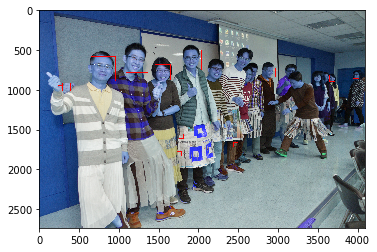

True

In [49]:
filename=r'D:\trydata\face\DSC_3425.jpg'

img = cv2.imread(filename)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(img,
                                          scaleFactor=1.2,
                                          minNeighbors=3,)
for (x,y,w,h) in faces:
    roi_gray = img[y:y+h, x:x+w]
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

from matplotlib import pyplot as plt
plt.imshow(img)
plt.show()
cv2.imwrite(r'D:\trydata\face\b_face.jpg', img)

In [57]:
import cv2
 
face_cascade = cv2.CascadeClassifier(r'D:\trydata\haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(r'D:\trydata\haarcascade_eye.xml')
 
face_filename = 1
def detect(filename):
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,
                                          scaleFactor=1.2,
                                          minNeighbors=3,)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray,
                                            scaleFactor=1.02,
                                            minNeighbors=3,)
        if len(eyes)>=2:
            f = cv2.resize(gray[y:y+h, x:x+w], (200, 200))
            global face_filename
            name = r'D:\trydata\face\openCVtry\face\%d.png' % face_filename
            cv2.imwrite(name, f)
            face_filename += 1
        else:
            pass
    print('Working with %s' % filename)

In [58]:
import os
 
dataDir=r"D:\trydata\face\openCVtry"
img_list = []
for fileNames in os.walk(dataDir):
    filename_extension = ['.jpg', '.png', '.jpeg', '.JPG', '.gif']
    for fe in filename_extension:
        for fileName in fileNames[-1]:
            if fileName.endswith(fe):
                img_list.append(fileName)
                
for img in img_list:
    detect(os.path.join(dataDir,img))

Working with D:\trydata\face\openCVtry\bb.jpg
Working with D:\trydata\face\openCVtry\DSC_3425.jpg
Working with D:\trydata\face\openCVtry\DSC_3430.jpg
Working with D:\trydata\face\openCVtry\johnsnow_test1.jpg
Working with D:\trydata\face\openCVtry\kit_with_rose.jpg
Working with D:\trydata\face\openCVtry\obama_and_biden.jpg
Working with D:\trydata\face\openCVtry\two_people.jpg


'bb.jpg'

In [71]:
import dlib
import cv2
import imutils

# 讀取照片圖檔
img = cv2.imread(r'D:\trydata\face\DSC_3425.jpg')

# 縮小圖片
img = imutils.resize(img, width=3000)

# Dlib 的人臉偵測器
detector = dlib.get_frontal_face_detector()

# 偵測人臉
face_rects = detector(img, 0)

# 取出所有偵測的結果
for i, d in enumerate(face_rects):
    x1 = d.left()
    y1 = d.top()
    x2 = d.right()
    y2 = d.bottom()

  # 以方框標示偵測的人臉
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 4, cv2.LINE_AA)

# 顯示結果
cv2.imshow("Face Detection", img)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [75]:
import dlib
import cv2
import imutils

img = cv2.imread(r'D:\trydata\face\DSC_3425.jpg')
img = imutils.resize(img, width=1280)
detector = dlib.get_frontal_face_detector()

# 偵測人臉，輸出分數
face_rects, scores, idx = detector.run(img, 0, -1)

for i, d in enumerate(face_rects):
    x1 = d.left()
    y1 = d.top()
    x2 = d.right()
    y2 = d.bottom()
    text = "%2.2f(%d)" % (scores[i], idx[i])

    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 4, cv2.LINE_AA)

    # 標示分數
    cv2.putText(img, text, (x1, y1), cv2.FONT_HERSHEY_DUPLEX,
          0.7, (255, 255, 255), 1, cv2.LINE_AA)

cv2.imshow("Face Detection", img)

cv2.waitKey(0)
cv2.destroyAllWindows()

# Use openCV only
https://github.com/informramiz/opencv-face-recognition-python

In [30]:
#import OpenCV module
import cv2
#import os module for reading training data directories and paths
import os
#import numpy to convert python lists to numpy arrays as 
#it is needed by OpenCV face recognizers
import numpy as np

#matplotlib for display our images
import matplotlib.pyplot as plt
%matplotlib inline 

In [31]:
subjects = ["", "Tom Cruise", "Shahrukh Khan"]

In [32]:
#function to detect face using OpenCV
def detect_face(img):
    #convert the test image to gray image as opencv face detector expects gray images
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #load OpenCV face detector, I am using LBP which is fast
    #there is alsface_cascade = o a more accurate but slow Haar classifier
    cv2.CascadeClassifier(r'D:\trydata\lbpcascade_frontalface.xml')

    #let's detect multiscale (some images may be closer to camera than others) images
    #result is a list of faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5);
    
    #if no faces are detected then return original img
    if (len(faces) == 0):
        return None, None
    
    #under the assumption that there will be only one face,
    #extract the face area
    (x, y, w, h) = faces[0]
    
    #return only the face part of the image
    return gray[y:y+w, x:x+h], faces[0]

In [33]:
#this function will read all persons' training images, detect face from each image
#and will return two lists of exactly same size, one list 
# of faces and another list of labels for each face
def prepare_training_data(data_folder_path):
    
    #------STEP-1--------
    #get the directories (one directory for each subject) in data folder
    dirs = os.listdir(data_folder_path)
    
    #list to hold all subject faces
    faces = []
    #list to hold labels for all subjects
    labels = []
    
    #let's go through each directory and read images within it
    for dir_name in dirs:
        
        #our subject directories start with letter 's' so
        #ignore any non-relevant directories if any
        if "." in dir_name:
            continue;
            
        #------STEP-2--------
        #extract label number of subject from dir_name
        #format of dir name = slabel
        #, so removing letter 's' from dir_name will give us label
        label = dir_name
        
        #build path of directory containin images for current subject subject
        #sample subject_dir_path = "training-data/s1"
        subject_dir_path = data_folder_path + "/" + dir_name
        
        #get the images names that are inside the given subject directory
        subject_images_names = os.listdir(subject_dir_path)
        
        #------STEP-3--------
        #go through each image name, read image, 
        #detect face and add face to list of faces
        for image_name in subject_images_names:
            
            #ignore system files like .DS_Store
            if image_name.startswith("."):
                continue;
            
            #build image path
            #sample image path = training-data/s1/1.pgm
            image_path = subject_dir_path + "/" + image_name

            #read image
            image = cv2.imread(image_path)
            
            #display an image window to show the image 
            cv2.imshow("Training on image...", image)
            cv2.waitKey(100)
            
            #detect face
            face, rect = detect_face(image)
            
            #------STEP-4--------
            #for the purpose of this tutorial
            #we will ignore faces that are not detected
            if face is not None:
                #add face to list of faces
                faces.append(face)
                #add label for this face
                labels.append(label)
            
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    cv2.destroyAllWindows()
    
    return faces, labels

In [34]:
#let's first prepare our training data
#data will be in two lists of same size
#one list will contain all the faces
#and other list will contain respective labels for each face
print("Preparing data...")
faces, labels = prepare_training_data(r"D:\trydata\face\train")
print("Data prepared")

#print total faces and labels
print("Total faces: ", len(faces))
print("Total labels: ", len(labels))

Preparing data...
Data prepared
Total faces:  13
Total labels:  13


In [35]:
#create our LBPH face recognizer 
# face_recognizer = cv2.face.createLBPHFaceRecognizer()
face_recognizer = cv2.face.LBPHFaceRecognizer_create()


#or use EigenFaceRecognizer by replacing above line with 
# face_recognizer = cv2.face.createEigenFaceRecognizer()
# face_recognizer = cv2.face.EigenFaceRecognizer_create()


#or use FisherFaceRecognizer by replacing above line with 
# face_recognizer = cv2.face.createFisherFaceRecognizer()
# face_recognizer = cv2.face.FisherFaceRecognizer_create()


# detector = cv2.CascadeClassifier(r"D:\trydata\haarcascade_frontalface_default.xml")



In [76]:
mapData={i:n for n,i in enumerate(set(labels))}
mapReturn={n:i for n,i in enumerate(set(labels))}
import numpy as np
labelArray=np.array([mapData[i] for i in labels])


In [77]:
#train our face recognizer of our training faces
face_recognizer.train(faces, labelArray)

In [78]:
#function to draw rectangle on image 
#according to given (x, y) coordinates and 
#given width and heigh
def draw_rectangle(img, rect):
    (x, y, w, h) = rect
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
#function to draw text on give image starting from
#passed (x, y) coordinates. 
def draw_text(img, text, x, y):
    cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 2)

In [79]:
#this function recognizes the person in image passed
#and draws a rectangle around detected face with name of the 
#subject
def predict(test_img):
    #make a copy of the image as we don't want to chang original image
    img = test_img.copy()
    #detect face from the image
    face, rect = detect_face(img)

    #predict the image using our face recognizer 
    label= face_recognizer.predict(face)
    #get name of respective label returned by face recognizer
    label_text = mapReturn[label[0]]
    
    #draw a rectangle around face detected
    draw_rectangle(img, rect)
    #draw name of predicted person
    draw_text(img, label_text, rect[0], rect[1]-5)
    
    return img

Predicting images...
Prediction complete


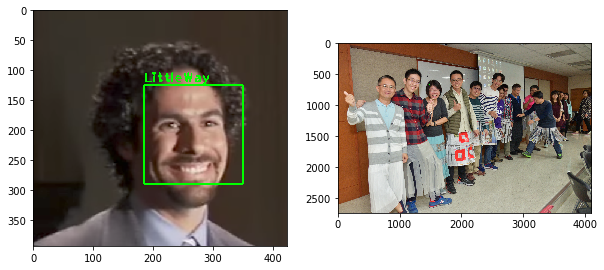

In [86]:
if __name__=="__main__":

    print("Predicting images...")

    #load test images
    test_img1 = cv2.imread(r"D:\trydata\face\test\alex-lacamoire.png")
    test_img2 = cv2.imread(r"D:\trydata\face\test\DSC_3425.jpg")

    #perform a prediction
    predicted_img1 = predict(test_img1)
    predicted_img2 = predict(test_img2)
    print("Prediction complete")

    #create a figure of 2 plots (one for each test image)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    #display test image1 result
    ax1.imshow(cv2.cvtColor(predicted_img1, cv2.COLOR_BGR2RGB))

    #display test image2 result
    ax2.imshow(cv2.cvtColor(predicted_img2, cv2.COLOR_BGR2RGB))

    #display both images
    cv2.imshow("Tom cruise test", predicted_img1)
    cv2.imshow("Shahrukh Khan test", predicted_img2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    cv2.destroyAllWindows()

In [7]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in d:\anaconda\lib\site-packages
Requirement already up-to-date: wheel>=0.26 in c:\users\andy.yuan\appdata\roaming\python\python36\site-packages (from tensorflow)
Requirement already up-to-date: protobuf>=3.4.0 in c:\users\andy.yuan\appdata\roaming\python\python36\site-packages (from tensorflow)
Requirement already up-to-date: absl-py>=0.1.6 in c:\users\andy.yuan\appdata\roaming\python\python36\site-packages (from tensorflow)
Requirement already up-to-date: gast>=0.2.0 in c:\users\andy.yuan\appdata\roaming\python\python36\site-packages (from tensorflow)
Requirement already up-to-date: grpcio>=1.8.6 in c:\users\andy.yuan\appdata\roaming\python\python36\site-packages (from tensorflow)
Requirement already up-to-date: termcolor>=1.1.0 in c:\users\andy.yuan\appdata\roaming\python\python36\site-packages (from tensorflow)
Requirement already up-to-date: tensorboard<1.9.0,>=1.8.0 in d:\anaconda\lib\site-packages (from tensorflow)
Requirement already u

In [8]:
import tensorflow

ImportError: Traceback (most recent call last):
  File "D:\anaconda\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 14, in swig_import_helper
    return importlib.import_module(mname)
  File "D:\anaconda\lib\importlib\__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 994, in _gcd_import
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load
  File "<frozen importlib._bootstrap>", line 955, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 658, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 571, in module_from_spec
  File "<frozen importlib._bootstrap_external>", line 922, in create_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
ImportError: DLL load failed with error code -1073741795

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\anaconda\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "D:\anaconda\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 17, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "D:\anaconda\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 16, in swig_import_helper
    return importlib.import_module('_pywrap_tensorflow_internal')
  File "D:\anaconda\lib\importlib\__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
ModuleNotFoundError: No module named '_pywrap_tensorflow_internal'


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [1]:
import keras

D:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "C:\Users\andy.yuan\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\Users\andy.yuan\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 35, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "C:\Users\andy.yuan\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 30, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "D:\anaconda\lib\imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "D:\anaconda\lib\imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: DLL load failed with error code -1073741795


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [109]:
from keras.preprocessing import image
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

model = VGGFace()

img = image.load_img('face1.png', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x)
preds = model.predict(x)
print('Predicted:', utils.decode_predictions(preds))

TypeError: softmax() got an unexpected keyword argument 'axis'

In [98]:
from Keras.engine import Model
from Keras.layers import Input
from Keras_vggface.vggface import VGGFace
from Keras.preprocessing import image
from Keras_vggface import utils

def extract(model, fn):
    img = image.load_img(fn, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = utils.preprocess_input(x)
    feats = model.predict(x)
    return feats

vgg_model = VGGFace()
out = vgg_model.get_layer('fc7').output
model = Model(vgg_model.input, out)
feats1=extract(model, 'face1.png')
feats2=extract(model, 'face2.png')

print(numpy.linalg.norm(feats1-feats2))
print(scipy.spatial.distance.cosine(feats1, feats2))

ModuleNotFoundError: No module named 'Keras'